## Understand Business Question- 
Question-Given historical hospital data, predict whether a diabetic patient will be readmitted within 30 days of discharge.
- Why it matters: Hospitals want to reduce unnecessary readmissions because they are costly and impact patient health.
- we are helping doctors and care managers by giving them a tool that says:
- This patient is likely to come back in 30 days, take  preventive action.
- model should classify a patient as high-risk or low-risk for readmission within 30 days.(classification
  problem)

### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")

In [2]:
#load dataset using CSV
data= pd.read_csv("diabetic_data.csv")

### Data Understanding

In [3]:
#load top rows
data.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [4]:
#load last rows
data.tail()

encounter_id  patient_nbr             race  gender      age weight  \
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discharge_disposition_id  admission_source_id  \
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
101761                       No                      No      Ch         Yes   
101762                       No                      No      No         Yes   
101763                       No                      No      Ch         Yes   
101764                       No                      No      Ch         Yes   
101765                       No                      No      No          No   

       readmitted  
101761        >30  
101762         NO  
101763         NO  
101764         NO  
101765         NO  

[5 rows x 50 columns]

In [5]:
#check shape of data
data.shape

(101766, 50)

In [6]:
#Quickly check missing values and dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
#Stastical Summary.
data.describe()

encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.000000          4.000000   
75%                    4.000000             7.000000          6.000000   
max                   28.000000            25.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count       101766.000000   101766.000000    101766.000000      101766.000000   
mean            43.095641        1.339730        16.021844           0.369357   
std             19.674362        1.705807         8.127566           1.267265   
min              1.000000        0.000000         1.000000           0.000000   
25%             31.000000        0.000000        10.000000           0.000000   
50%             44.000000        1.000000        15.000000           0.000000   
75%             57.000000        2.000000        20.000000           0.000000   
max            132.000000        6.000000        81.000000          42.000000   

       number_emergency  number_inpatient  number_diagnoses  
count     101766.000000     101766.000000     101766.000000  
mean           0.197836          0.635566          7.422607  
std            0.930472          1.262863          1.933600  
min            0.000000          0.000000          1.000000  
25%            0.000000          0.000000          6.000000  
50%            0.000000          0.000000          8.000000  
75%            0.000000          1.000000          9.000000  
max           76.000000         21.000000         16.000000

# What I understand?
- 1.datasets are large and some non-predictive     features. 
- 2.mix of categorical and numerical features.
- 3.Many count-based features are skewed
- 4.some features has missing value
- 5.some features keep "?" as missing value

In [8]:
#divide data into numerical and catogorical
print("According to the data there are 50 columns")

# Numerical columns
numeric_cols = data.select_dtypes(include=[np.number])

# Categorical columns
categorical_cols = data.select_dtypes(include=['object', 'category'])

print("Total Numerical columns:", len(numeric_cols.columns))
print("Total Categorical columns:", len(categorical_cols.columns))


According to the data there are 50 columns
Total Numerical columns: 13
Total Categorical columns: 37


### Data Cleaning & Preprocessing 1

In [9]:
#check duplicate rows
data.duplicated().sum()


0

In [10]:
#check missing values for numeric columns.
data.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [11]:
#check percentage
missing_percent = data[['max_glu_serum', 'A1Cresult']].isna().mean() * 100
print(missing_percent)


max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


# handle missing values
- We never drop based only on % missing.
- do univariate analysis.
- understand relation with target and if feature is important for prediction
  then we keep them.

# max_glu_serum
- max_glu_serum = maximum glucose level measured during hospital stay.

In [12]:
#univariate analysis
data["max_glu_serum"].value_counts()

max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64

In [13]:
#check relation with target
pd.crosstab(data['max_glu_serum'], data['readmitted'], normalize='index')

readmitted          <30       >30        NO
max_glu_serum                              
>200           0.124579  0.356902  0.518519
>300           0.143196  0.412184  0.444620
Norm           0.113593  0.340778  0.545630

In [14]:
#stastical test
from scipy.stats import chi2_contingency
contingency = pd.crosstab(data['max_glu_serum'], data['readmitted'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("p-value:", p)

p-value: 4.40965642294135e-07


In [15]:
data['max_glu_serum'] = data['max_glu_serum'].fillna('Not Measured')


In [16]:
data['max_glu_serum'] = data['max_glu_serum'].replace({
    'Not Measured': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})

# Insights
- Clinically, this directly relates to diabetes severity, so it should impact readmission.
- p value shows There is a statistically significant association between max_glu_serum and readmitted
- Low cardinality (only 3 categories)
- As glucose increases:
- <30 readmission increases,NO decreases
- This is a clear monotonic trend


# A1Cresult
- 1C measures average blood glucose over ~3 months

In [17]:
data['A1Cresult'].value_counts()


A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64

In [18]:
pd.crosstab(data['A1Cresult'], data['readmitted'], normalize='index')

readmitted       <30       >30        NO
A1Cresult                               
>7          0.100472  0.341028  0.558499
>8          0.098710  0.353092  0.548199
Norm        0.096593  0.320441  0.582966

In [19]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab(data['A1Cresult'], data['readmitted'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("p-value:", p)

p-value: 0.0021280034928395078


In [20]:
data['A1Cresult'] = data['A1Cresult'].fillna('Not Measured')

In [21]:
data['max_glu_serum'] = data['max_glu_serum'].replace({
    'Not Measured': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})
data['A1Cresult'] = data['A1Cresult'].replace({
    'Not Measured': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
})

In [22]:
data['A1Cresult'].value_counts()

A1Cresult
0    84748
3     8216
1     4990
2     3812
Name: count, dtype: int64

# Insights:
## A1Cresult = Norm
- Patients with normal A1C are less likely to be readmitted
- Majority (58%) are not readmitted
## A1Cresult = >7
- Readmission risk is slightly higher
- More patients return after 30 days compared to Norm
## A1Cresult = >8
- Understanding:
- Worst glucose control
- Highest >30-day readmission
- Lowest “NO readmission” rate
- Key pattern (this is the insight)-
- As A1C increases = readmission probability increases
- This shows a monotonic medical relationship, which is very valuable.
- I handle it carefully using encoding


In [23]:
data.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [24]:
#checking if there are any special characters in the data or not
for i in data.columns:
    if data[i].dtype==object:
        print(i,data[i][data[i]== "?"].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [25]:
summary = []

for col in data.columns:
    # % NaN missing
    nan_percent = data[col].isna().mean() * 100
    
    # count of '?' (only for object columns)
    q_count = (data[col] == '?').sum() if data[col].dtype == 'object' else 0
    
    # total missing %
    total_missing = nan_percent + (q_count / len(data) * 100)
    
    # keep ONLY columns with missing > 0
    if total_missing > 0:
        summary.append([
            col,
            round(nan_percent, 2),
            q_count,
            round(total_missing, 2)
        ])

missing_df = pd.DataFrame(
    summary,
    columns=['Column', '% NaN Missing', "'?' Count", 'Total Missing %']
).sort_values('Total Missing %', ascending=False)

missing_df


Column  % NaN Missing  '?' Count  Total Missing %
1             weight            0.0      98569            96.86
3  medical_specialty            0.0      49949            49.08
2         payer_code            0.0      40256            39.56
0               race            0.0       2273             2.23
6             diag_3            0.0       1423             1.40
5             diag_2            0.0        358             0.35
4             diag_1            0.0         21             0.02

# Weight

In [26]:
data["weight"].value_counts()

weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64

In [27]:
pd.crosstab(data['weight'], data['readmitted'], normalize='index')

readmitted       <30       >30        NO
weight                                  
>200        0.000000  1.000000  0.000000
?           0.111597  0.345291  0.543112
[0-25)      0.166667  0.645833  0.187500
[100-125)   0.107200  0.467200  0.425600
[125-150)   0.082759  0.475862  0.441379
[150-175)   0.085714  0.457143  0.457143
[175-200)   0.090909  0.454545  0.454545
[25-50)     0.082474  0.432990  0.484536
[50-75)     0.117057  0.433668  0.449275
[75-100)    0.114521  0.496257  0.389222

## observation Weight Feature
- Almost 97% of rows have '?'
- Only ~3% actual values
- Weight had extremely high missingness making it statistically unreliable and likely to introduce noise.
- Drop weight

# Medical_speciality

In [28]:
data["medical_specialty"].value_counts()

medical_specialty
?                                49949
InternalMedicine                 14635
Emergency/Trauma                  7565
Family/GeneralPractice            7440
Cardiology                        5352
                                 ...  
SportsMedicine                       1
Speech                               1
Perinatology                         1
Neurophysiology                      1
Pediatrics-InfectiousDiseases        1
Name: count, Length: 73, dtype: int64

In [29]:
pd.crosstab(data['medical_specialty'], data['readmitted'], normalize='index')

readmitted                             <30       >30        NO
medical_specialty                                             
?                                 0.115738  0.364692  0.519570
AllergyandImmunology              0.428571  0.428571  0.142857
Anesthesiology                    0.083333  0.250000  0.666667
Anesthesiology-Pediatric          0.052632  0.263158  0.684211
Cardiology                        0.079410  0.346226  0.574365
...                                    ...       ...       ...
Surgery-PlasticwithinHeadandNeck  0.000000  1.000000  0.000000
Surgery-Thoracic                  0.100917  0.275229  0.623853
Surgery-Vascular                  0.138837  0.375235  0.485929
SurgicalSpecialty                 0.060606  0.272727  0.666667
Urology                           0.099270  0.270073  0.630657

[73 rows x 3 columns]

# Notes medical_speciality:
- Very high missingness (? ≈ 49%)not random
- High cardinality (73 categories)
- Severe sparsity (many categories with 1–5 samples)
- This is already a red flag for modeling.
- Statistically:
 There iS a dependency between medical_specialty and       readmitted
- High risk of overfitting and poor generalization

# payer_code

In [30]:
#payer_code
data["payer_code"].value_counts()

payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64

In [31]:
##Does payer_code change the readmission behavior meaningfully?

pd.crosstab(data['payer_code'], data['readmitted'], normalize='index')


readmitted       <30       >30        NO
payer_code                              
?           0.114939  0.343502  0.541559
BC          0.091515  0.279484  0.629001
CH          0.089041  0.226027  0.684932
CM          0.102220  0.341249  0.556531
CP          0.084485  0.308330  0.607185
DM          0.116576  0.400729  0.482696
FR          0.000000  0.000000  1.000000
HM          0.102646  0.369780  0.527574
MC          0.117451  0.369370  0.513179
MD          0.117780  0.356455  0.525764
MP          0.113924  0.493671  0.392405
OG          0.131655  0.322362  0.545983
OT          0.073684  0.400000  0.526316
PO          0.074324  0.243243  0.682432
SI          0.127273  0.309091  0.563636
SP          0.101857  0.373277  0.524865
UN          0.092729  0.284314  0.622958
WC          0.037037  0.177778  0.785185

## Notes for Payer_code
- High missing rate (~40%)
- Weak effect size (probabilities overlap)
- Administrative feature (not patient physiology)
- Risk of learning hospital / insurance bias
- Encoding adds dimensions without strong signal

# race

In [32]:
data["race"].value_counts()

race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

In [33]:
#Check distribution of race vs readmission
pd.crosstab(data['race'], data['readmitted'], normalize='index')

readmitted            <30       >30        NO
race                                         
?                0.082710  0.236692  0.680598
AfricanAmerican  0.112181  0.345341  0.542478
Asian            0.101404  0.251170  0.647426
Caucasian        0.112906  0.356430  0.530664
Hispanic         0.104075  0.315169  0.580756
Other            0.096282  0.296149  0.607570

In [34]:
#Statistical test (Chi-Square)
contingency = pd.crosstab(data['race'], data['readmitted'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square p-value:", p)


Chi-square p-value: 7.379468859169466e-55


### Race Feature Notes

- Chi-square p-value = 7.38e-55 → strongly associated with readmission
- Row-wise distribution shows higher readmission for AfricanAmerican and Caucasian
- Missing values '?' grouped as 'Unknown'
- Rare categories can be grouped to reduce noise
- Feature importance validated in tree-based model

In [35]:
data["diag_3"].value_counts()

diag_3
250     11555
401      8289
276      5175
428      4577
427      3955
        ...  
657         1
684         1
603         1
E826        1
971         1
Name: count, Length: 790, dtype: int64

In [36]:
pd.crosstab(data['diag_3'], data['readmitted'], normalize='index')

readmitted       <30       >30        NO
diag_3                                  
11          0.500000  0.000000  0.500000
110         0.100000  0.300000  0.600000
111         1.000000  0.000000  0.000000
112         0.106796  0.354369  0.538835
115         0.000000  0.000000  1.000000
...              ...       ...       ...
V66         0.055556  0.166667  0.777778
V70         0.000000  0.000000  1.000000
V72         0.125000  0.125000  0.750000
V85         0.093750  0.229167  0.677083
V86         0.000000  0.333333  0.666667

[790 rows x 3 columns]

In [37]:
data["diag_2"].value_counts()

diag_2
276     6752
428     6662
250     6071
427     5036
401     3736
        ... 
E918       1
46         1
V13        1
E850       1
927        1
Name: count, Length: 749, dtype: int64

In [38]:
pd.crosstab(data['diag_2'], data['readmitted'], normalize='index')

readmitted       <30       >30        NO
diag_2                                  
11          0.333333  0.333333  0.333333
110         0.250000  0.375000  0.375000
111         0.000000  0.000000  1.000000
112         0.139303  0.373134  0.487562
114         1.000000  0.000000  0.000000
...              ...       ...       ...
V69         0.000000  0.000000  1.000000
V70         0.000000  0.428571  0.571429
V72         0.000000  0.076923  0.923077
V85         0.130178  0.213018  0.656805
V86         0.000000  0.500000  0.500000

[749 rows x 3 columns]

In [39]:
data["diag_1"].value_counts()

diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
373       1
314       1
684       1
217       1
V51       1
Name: count, Length: 717, dtype: int64

In [40]:
pd.crosstab(data['diag_1'], data['readmitted'], normalize='index')

readmitted       <30       >30        NO
diag_1                                  
10          0.000000  0.000000  1.000000
11          0.000000  0.300000  0.700000
110         0.000000  0.500000  0.500000
112         0.191781  0.356164  0.452055
114         0.000000  1.000000  0.000000
...              ...       ...       ...
V63         0.125000  0.125000  0.750000
V66         0.000000  0.000000  1.000000
V67         0.000000  1.000000  0.000000
V70         0.000000  0.000000  1.000000
V71         0.000000  0.222222  0.777778

[717 rows x 3 columns]

In [41]:
cols_to_drop = [
    "weight",
    'medical_specialty',
    'payer_code'
]

data = data.drop(columns=cols_to_drop)


In [42]:
#keep columns and replace with unknown.
#decide in advance feature selection
cols = ['race',"diag_1","diag_2","diag_3"]
data[cols] = data[cols].replace('?', 'Unknown')


Note-
- High missing = low reliability
- High missing + high cardinality + low domain impact = Drop
- I dropped them to reduce noise and model complexity.
- Dropping is a strength, not a weakness.


- race',"diag_1","diag_2","diag_3 this Replace '?' with 'Unknown'-
- I replaced rare categories and missing indicators with grouped representations to reduce noise while preserving signal.
- This improved generalization and model stability.


In [43]:
data.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)


no clinical meaning it is just identifiers
high cardinality

# Age

In [44]:
data["age"].value_counts()

age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

- it shows the age range between 0 to 100
- most of the population come under 50 to 80
- we assume that age of the patient on average lies at the midpoint of the age category
- e.g (40-50)=45years


In [45]:
data["age"].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [46]:
age_midpoint = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

data['age'] = data['age'].map(age_midpoint)


In [47]:
data["age"].value_counts()

age
75    26068
65    22483
55    17256
85    17197
45     9685
35     3775
95     2793
25     1657
15      691
5       161
Name: count, dtype: int64

# admission_type_id

In [48]:
data["admission_type_id"].value_counts()

admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64

In [49]:
pd.crosstab(
    data['admission_type_id'],
    data['readmitted'],
    normalize='index'
)

readmitted              <30       >30        NO
admission_type_id                              
1                  0.115225  0.357640  0.527135
2                  0.111797  0.349134  0.539069
3                  0.103927  0.304521  0.591552
4                  0.100000  0.200000  0.700000
5                  0.103448  0.359666  0.536886
6                  0.110754  0.421659  0.467586
7                  0.000000  0.000000  1.000000
8                  0.084375  0.262500  0.653125

In [50]:
ID_map=pd.read_csv("IDS_mapping.csv")

In [51]:
ID_map.loc[:,["admission_type_id","description"]].head(8)

admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available
5                 6            NaN
6                 7  Trauma Center
7                 8     Not Mapped

# According to ID's Mapping:
- These 8 values correspond to
- Emergency
- Urgent
- Elective
- Newborn
- Not Available
- NaN
- Trauma Center
- Not Mapped

-    The ID values are categorical codes without ordinal       meaning.
-    I mapped them to descriptive categories using a     
     lookup table so the model could learn meaningful patterns.

In [52]:
admission_group_map = {
    1: "Emergency",
    2: "Emergency",
    7: "Emergency",
    3: "Elective",
    4: "Newborn",
    5: "Not Available",
    6: "Not Available",
    8: "Not Available"
}

data["admission_type_id"] = data["admission_type_id"].map(admission_group_map)


In [53]:
#newborn not have diabetes,clinically irrelevant.
data = data[data['admission_type_id'] != 'Newborn']

In [54]:
data["admission_type_id"].value_counts()

admission_type_id
Emergency        72491
Elective         18869
Not Available    10396
Name: count, dtype: int64

# gender

In [55]:
data["gender"].value_counts()

gender
Female             54705
Male               47048
Unknown/Invalid        3
Name: count, dtype: int64

In [56]:
#drop
data = data[data['gender'] != 'Unknown/Invalid']


In [57]:
data["gender"].value_counts()

gender
Female    54705
Male      47048
Name: count, dtype: int64

# discharge_disposition_id

In [58]:
data["discharge_disposition_id"].value_counts()

discharge_disposition_id
1     60226
3     13954
6     12898
18     3691
2      2128
22     1992
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64

# According to ID'd mapping:


In [59]:
data["discharge_disposition_id"].unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27], dtype=int64)

In [60]:
discharge_map = ID_map.iloc[10:40].copy()
discharge_map.columns = ['discharge_disposition_id', 'discharge_description']
discharge_map = discharge_map.reset_index(drop=True)
discharge_map

discharge_disposition_id                              discharge_description
0                         1                                 Discharged to home
1                         2  Discharged/transferred to another short term h...
2                         3                      Discharged/transferred to SNF
3                         4                      Discharged/transferred to ICF
4                         5  Discharged/transferred to another type of inpa...
5                         6  Discharged/transferred to home with home healt...
6                         7                                           Left AMA
7                         8  Discharged/transferred to home under care of H...
8                         9          Admitted as an inpatient to this hospital
9                        10  Neonate discharged to another hospital for neo...
10                       11                                            Expired
11                       12  Still patient or expected to return for outpat...
12                       13                                     Hospice / home
13                       14                         Hospice / medical facility
14                       15  Discharged/transferred within this institution...
15                       16  Discharged/transferred/referred another instit...
16                       17  Discharged/transferred/referred to this instit...
17                       18                                                NaN
18                       19           Expired at home. Medicaid only, hospice.
19                       20  Expired in a medical facility. Medicaid only, ...
20                       21    Expired, place unknown. Medicaid only, hospice.
21                       22  Discharged/transferred to another rehab fac in...
22                       23  Discharged/transferred to a long term care hos...
23                       24  Discharged/transferred to a nursing facility c...
24                       25                                         Not Mapped
25                       26                                    Unknown/Invalid
26                       30  Discharged/transferred to another Type of Heal...
27                       27  Discharged/transferred to a federal health car...
28                       28  Discharged/transferred/referred to a psychiatr...
29                       29  Discharged/transferred to a Critical Access Ho...

In [61]:
data["discharge_disposition_id"] = data["discharge_disposition_id"].replace({
    1: "Discharged to home",
    6: "Discharged to home",
    8: "Discharged to home",
    2: "Transferred to another city",
    3: "Transferred to another city",
    4: "Transferred to another city",
    5: "Transferred to another city",
    16: "Transferred to another city",
    22: "Transferred to another city",
    23: "Transferred to another city",
    24:"Transferred to another city",
    27:"Transferred to another city",
    28:"Transferred to another city",
    29:"Transferred to another city",
    30:"Transferred to another city",
    7: "Left AMA",
    9:"Still patient/referred to this institution",
    12:"Still patient/referred to this institution",
    15:"Still patient/referred to this institution",
    17:"Still patient/referred to this institution",
    10:"Neonate discharged",
    11:"Expired",
    19:"Expired",
    20:"Expired",
    21:"Expired",
    13:"Hospice",
    14:"Hospice",
    18:"Not Available",
    25:"Not Available",
    26:"Not Available"
    
})


In [62]:
data["discharge_disposition_id"].value_counts()

discharge_disposition_id
Discharged to home                            73232
Transferred to another city                   20688
Not Available                                  4680
Expired                                        1652
Hospice                                         771
Left AMA                                        623
Still patient/referred to this institution      101
Neonate discharged                                6
Name: count, dtype: int64

In [63]:
data=data[data["discharge_disposition_id"]!="Expired"]
data=data[data["discharge_disposition_id"]!= "Neonate discharged"]
data=data[data["discharge_disposition_id"]!="Hospice"]


In [64]:
data["discharge_disposition_id"].value_counts()


discharge_disposition_id
Discharged to home                            73232
Transferred to another city                   20688
Not Available                                  4680
Left AMA                                        623
Still patient/referred to this institution      101
Name: count, dtype: int64

In [65]:
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

# admission_source_id

In [66]:
data["admission_source_id"].value_counts()

admission_source_id
7     55843
1     29162
17     6570
4      3113
6      2239
2      1081
5       806
3       185
20      159
9       125
8        15
22       12
10        8
11        2
25        2
14        1
13        1
Name: count, dtype: int64

In [67]:
data["admission_source_id"].nunique()

17

In [68]:
#admission_source_id description
admission_map = ID_map.iloc[42:69].copy()
admission_map.columns = ['admission_source_id', 'admission_source_description']
admission_map = admission_map.reset_index(drop=True)
admission_map

admission_source_id                       admission_source_description
0                    1                                 Physician Referral
1                    2                                    Clinic Referral
2                    3                                       HMO Referral
3                    4                           Transfer from a hospital
4                    5     Transfer from a Skilled Nursing Facility (SNF)
5                    6         Transfer from another health care facility
6                    7                                     Emergency Room
7                    8                              Court/Law Enforcement
8                    9                                      Not Available
9                   10              Transfer from critial access hospital
10                  11                                    Normal Delivery
11                  12                                 Premature Delivery
12                  13                                          Sick Baby
13                  14                                   Extramural Birth
14                  15                                      Not Available
15                  17                                                NaN
16                  18           Transfer From Another Home Health Agency
17                  19             Readmission to Same Home Health Agency
18                  20                                         Not Mapped
19                  21                                    Unknown/Invalid
20                  22   Transfer from hospital inpt/same fac reslt in...
21                  23                          Born inside this hospital
22                  24                         Born outside this hospital
23                  25            Transfer from Ambulatory Surgery Center
24                  26                              Transfer from Hospice

# we are merging several categories of admission_source_id into fewer categories:


In [69]:
data["admission_source_id"] = data["admission_source_id"].replace({ 
    1: "Referral", 
    2: "Referral",
    3: "Referral", 
    4: "Transferred from hospital", 
    5: "Transferred from hospital", 
    6: "Transferred from hospital", 
    10: "Transferred from hospital", 
    18: "Transferred from hospital", 
    22: "Transferred from hospital", 
    25: "Transferred from hospital", 
    26: "Transferred from hospital", 
    7:  "Emergency", 
    19: "Home Health",
    11: "Birth", 
    12: "Birth", 
    13: "Birth", 
    14: "Birth", 
    23: "Birth", 
    24: "Birth", 
    9: "Unknown", 
    15: "Unknown", 
    17: "Unknown", 
    20: "Unknown", 
    21: "Unknown" 
})

In [70]:
data["admission_source_id"].value_counts()

admission_source_id
Emergency                    55843
Referral                     30428
Unknown                       6854
Transferred from hospital     6180
8                               15
Birth                            4
Name: count, dtype: int64

In [71]:
data["admission_source_id"] = data["admission_source_id"].replace({
    "Transfer from hospital": "Transferred from hospital",
    "Transferred from hospital": "Transferred from hospital"
})


In [72]:
data = data[data["admission_source_id"] != "Birth"]
data = data[data["admission_source_id"] != "Legal"]


In [73]:
data["admission_source_id"].value_counts()

admission_source_id
Emergency                    55843
Referral                     30428
Unknown                       6854
Transferred from hospital     6180
8                               15
Name: count, dtype: int64

In [74]:
data["time_in_hospital"].value_counts(sort=False)

time_in_hospital
1     13822
3     17425
2     16886
4     13682
5      9747
13     1152
12     1383
9      2878
7      5696
10     2262
6      7354
11     1770
8      4268
14      995
Name: count, dtype: int64

- The time in the hospital ranges from 1 day to 14 days

# num_lab_procedures

In [75]:
data["num_lab_procedures"].unique()

array([ 41,  59,  11,  44,  51,  31,  70,  73,  68,  33,  47,  62,  60,
        55,  49,  75,  45,  29,  35,  42,  66,  36,  19,  64,  25,  53,
        52,  87,  27,  37,  28,  48,  10,   2,  65,  67,  40,  54,  58,
        57,  43,  32,  83,  34,  39,  69,  38,  72,  22,  96,  46,  78,
        56,  61,  88,  50,   1,  18,  82,   9,  63,  24,  71,  77,  81,
        76,  90,  93,   3, 103,  13,  80,  85,  16,  15,  12,  30,  23,
        17,  21,  79,  26,   5,  95,  97,  84,  14,  74, 105,  86,  98,
        20,   6,  94,   8, 102,   7,  89,  91,  92,   4, 101,  99, 100,
       114, 113, 111, 129, 107, 108, 106, 104, 109, 120, 132, 121, 126,
       118], dtype=int64)

In [76]:
print(
    "The number of lab tests a patient has undergone can range from",
    data["num_lab_procedures"].min(),
    "to",
    data["num_lab_procedures"].max()
)


The number of lab tests a patient has undergone can range from 1 to 132


In [77]:
data.num_procedures.value_counts()

num_procedures
0    45672
1    20246
2    12366
3     9202
6     4799
4     4048
5     2987
Name: count, dtype: int64

In [78]:
print(
    "The number of medications ranges from a minimum of",
    data["num_medications"].min(),
    "to a maximum of",
    data["num_medications"].max()
)


The number of medications ranges from a minimum of 1 to a maximum of 81


In [79]:
data["number_outpatient"].value_counts()

number_outpatient
0     82973
1      8348
2      3509
3      1996
4      1077
5       514
6       294
7       154
8        96
9        82
10       57
11       41
13       30
12       29
14       28
15       20
16       13
17        8
21        6
20        6
18        5
22        5
19        3
27        3
24        3
26        2
23        2
33        2
35        2
36        2
29        2
39        1
34        1
42        1
25        1
28        1
37        1
38        1
40        1
Name: count, dtype: int64

In [80]:
data["number_emergency"].value_counts()

number_emergency
0     88226
1      7474
2      1984
3       706
4       369
5       190
6        93
7        72
8        50
10       34
9        33
11       23
13       12
12       10
22        6
16        5
18        5
19        4
20        4
15        3
14        3
25        2
21        2
28        1
42        1
46        1
76        1
37        1
64        1
63        1
54        1
24        1
29        1
Name: count, dtype: int64

In [81]:
data["number_inpatient"].value_counts()

number_inpatient
0     66227
1     18980
2      7299
3      3271
4      1574
5       791
6       474
7       262
8       145
9       109
10       59
11       49
12       32
13       18
14       10
15        9
16        6
19        2
17        1
21        1
18        1
Name: count, dtype: int64

# insights-
- Most patients have 0 outpatient or emergency visits

- Most patients have 0–1 inpatient visits

- There are a few patients with very high numbers

In [82]:
#corr
data[["number_outpatient","number_emergency","number_inpatient"]].corr()
#carry diffrent information

number_outpatient  number_emergency  number_inpatient
number_outpatient           1.000000          0.091664          0.108012
number_emergency            0.091664          1.000000          0.267697
number_inpatient            0.108012          0.267697          1.000000

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(data[["number_outpatient","number_emergency","number_inpatient"]])
print(pca.explained_variance_ratio_)


[0.45775321]


# Insights-
- All three represent healthcare usage
- All three measure burden on hospital system
- All three reflect patient severity & follow-up
- Keep all three columns separate and use them as-is for now.
- not correlated with each other 
Later, I you want to experiment with linear models, I can combine or log-transform..
- PCA says They don’t collapse into one strong dimension

In [84]:
data["service_utilization"] = (
    data["number_outpatient"] +
    data["number_emergency"] +
    data["number_inpatient"]
)

In [85]:
data["service_utilization"].describe()


count    99320.000000
mean         1.198802
std          2.294416
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         80.000000
Name: service_utilization, dtype: float64

In [86]:
data.groupby("readmitted")["service_utilization"].mean()


readmitted
<30    2.017502
>30    1.619478
NO     0.738055
Name: service_utilization, dtype: float64

In [87]:
data.drop(
    columns=["number_outpatient","number_emergency","number_inpatient"],
    inplace=True
)


In [88]:
data["number_diagnoses"].value_counts()

number_diagnoses
9     47803
5     11293
8     10359
7     10212
6      9984
4      5498
3      2822
2      1021
1       219
16       42
13       16
10       16
11       11
15       10
12        8
14        6
Name: count, dtype: int64

In [89]:
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'service_utilization'],
      dtype='object')

In [90]:
data.head(5)

race  gender  age admission_type_id discharge_disposition_id  \
0        Caucasian  Female    5     Not Available            Not Available   
1        Caucasian  Female   15         Emergency       Discharged to home   
2  AfricanAmerican  Female   25         Emergency       Discharged to home   
3        Caucasian    Male   35         Emergency       Discharged to home   
4        Caucasian    Male   45         Emergency       Discharged to home   

  admission_source_id  time_in_hospital  num_lab_procedures  num_procedures  \
0            Referral                 1                  41               0   
1           Emergency                 3                  59               0   
2           Emergency                 2                  11               5   
3           Emergency                 2                  44               1   
4           Emergency                 1                  51               0   

   num_medications  ... insulin glyburide-metformin glipizide-metformin  \
0                1  ...      No                  No                  No   
1               18  ...      Up                  No                  No   
2               13  ...      No                  No                  No   
3               16  ...      Up                  No                  No   
4                8  ...  Steady                  No                  No   

   glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  \
0                        No                       No                      No   
1                        No                       No                      No   
2                        No                       No                      No   
3                        No                       No                      No   
4                        No                       No                      No   

  change diabetesMed readmitted service_utilization  
0     No          No         NO                   0  
1     Ch         Yes        >30                   0  
2     No         Yes         NO                   3  
3     Ch         Yes         NO                   0  
4     Ch         Yes         NO                   0  

[5 rows x 43 columns]

# data cleaning part 1 Done

- I done the essential data preparation steps 
- I handle the missing and now data looks clean.

# ----------------------------------------------------------------------------------------------------------

# Advance data cleaning 2:

# Encoding-
- decide strategy according to the column type.

# Target variable
- It tells whether a patient was readmitted to the hospital after discharge.
- readmitted is your target variable (what we are trying to predict)

In [91]:
data["readmitted"].value_counts()

readmitted
NO     52511
>30    35496
<30    11313
Name: count, dtype: int64

In [92]:
#readmission converting multiclass to binary class
data['readmitted'] = data['readmitted'].replace(
    {'<30': 1, '>30': 0, 'NO': 0}
)


In [93]:
#verify
data["readmitted"].value_counts()

readmitted
0    88007
1    11313
Name: count, dtype: int64

<Axes: xlabel='readmitted', ylabel='count'>

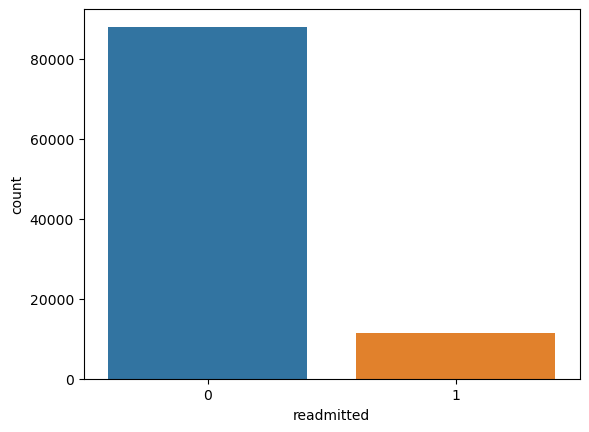

In [94]:
sns.countplot(x='readmitted', data=data)


## Imbalanced data
- 1=Good Healthcare not provided to the patients
- 0=Provided Good service


In [95]:
data['A1Cresult'] = data['A1Cresult'].replace({
    'Not Measured': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3
})

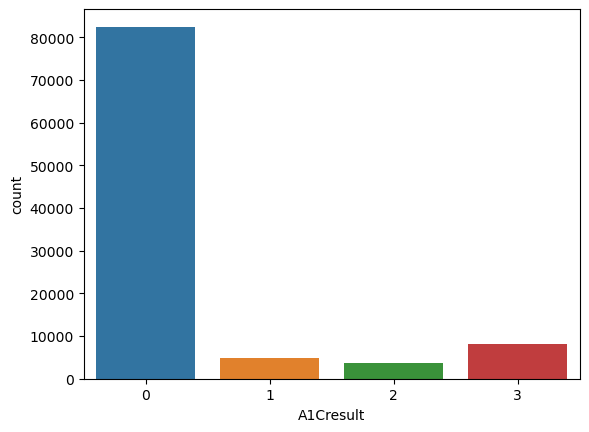

In [96]:
sns.countplot(x='A1Cresult', data=data)
plt.show()

In [97]:
data['max_glu_serum'] = data['max_glu_serum'].replace({
    'Not Measured': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
})

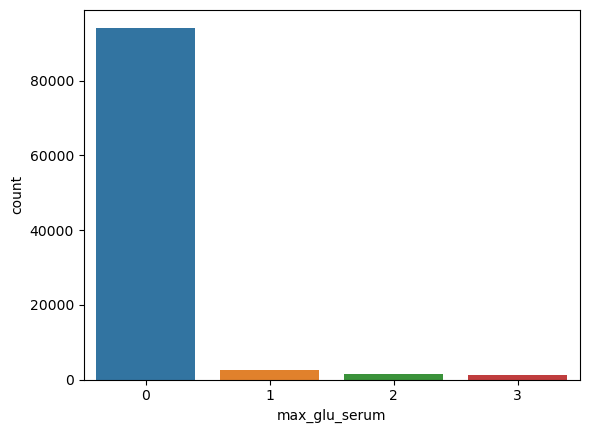

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='max_glu_serum', data=data)
plt.show()


In [99]:
data["gender"]=data["gender"].replace({"Female":0,"Male":1})

In [100]:
data["gender"]

0         0
1         0
2         0
3         1
4         1
         ..
101761    1
101762    0
101763    1
101764    0
101765    1
Name: gender, Length: 99320, dtype: int64

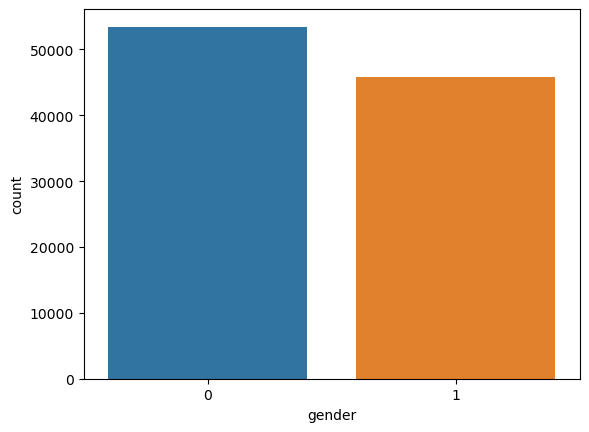

In [101]:
sns.countplot(x='gender', data=data)
plt.show()


In [102]:
data["change"].value_counts()

change
No    53205
Ch    46115
Name: count, dtype: int64

In [103]:
data["change"]=data["change"].replace({"No":0,"Ch":1})

In [104]:
data['diabetesMed']=data['diabetesMed'].replace("Yes",1)
data['diabetesMed']=data['diabetesMed'].replace("No",0)

In [105]:
data['diabetesMed'].value_counts()

diabetesMed
1    76701
0    22619
Name: count, dtype: int64

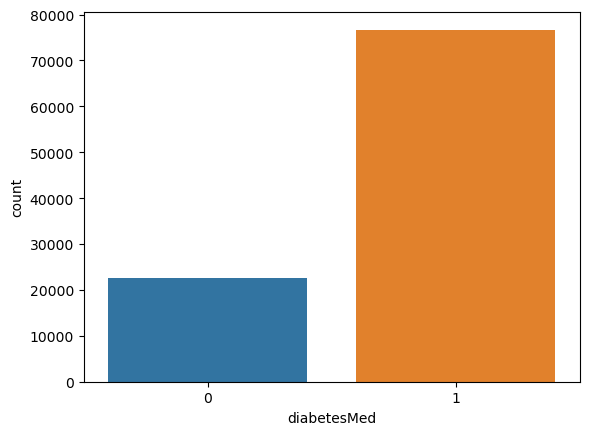

In [106]:
sns.countplot(x='diabetesMed', data=data)
plt.show()


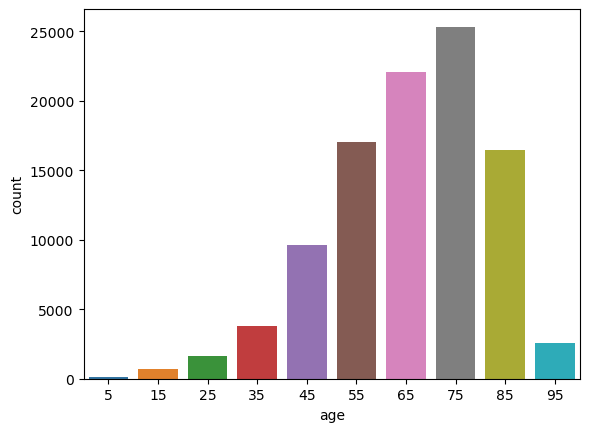

In [107]:
sns.countplot(x='age', data=data)
plt.show()


<Axes: xlabel='service_utilization'>

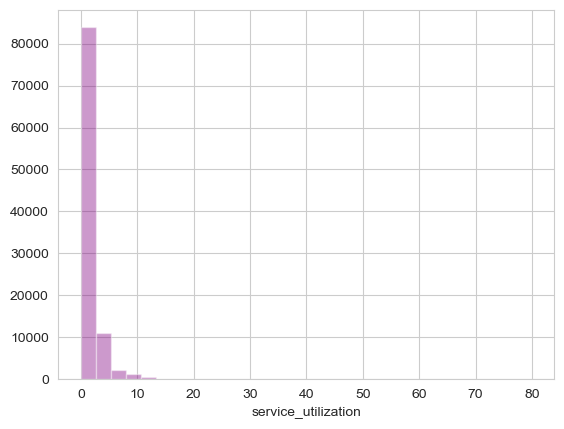

In [108]:
# set the background style of the plot
sns.set_style('whitegrid')
sns.distplot(data['service_utilization'], kde = False, color ='purple', bins = 30)

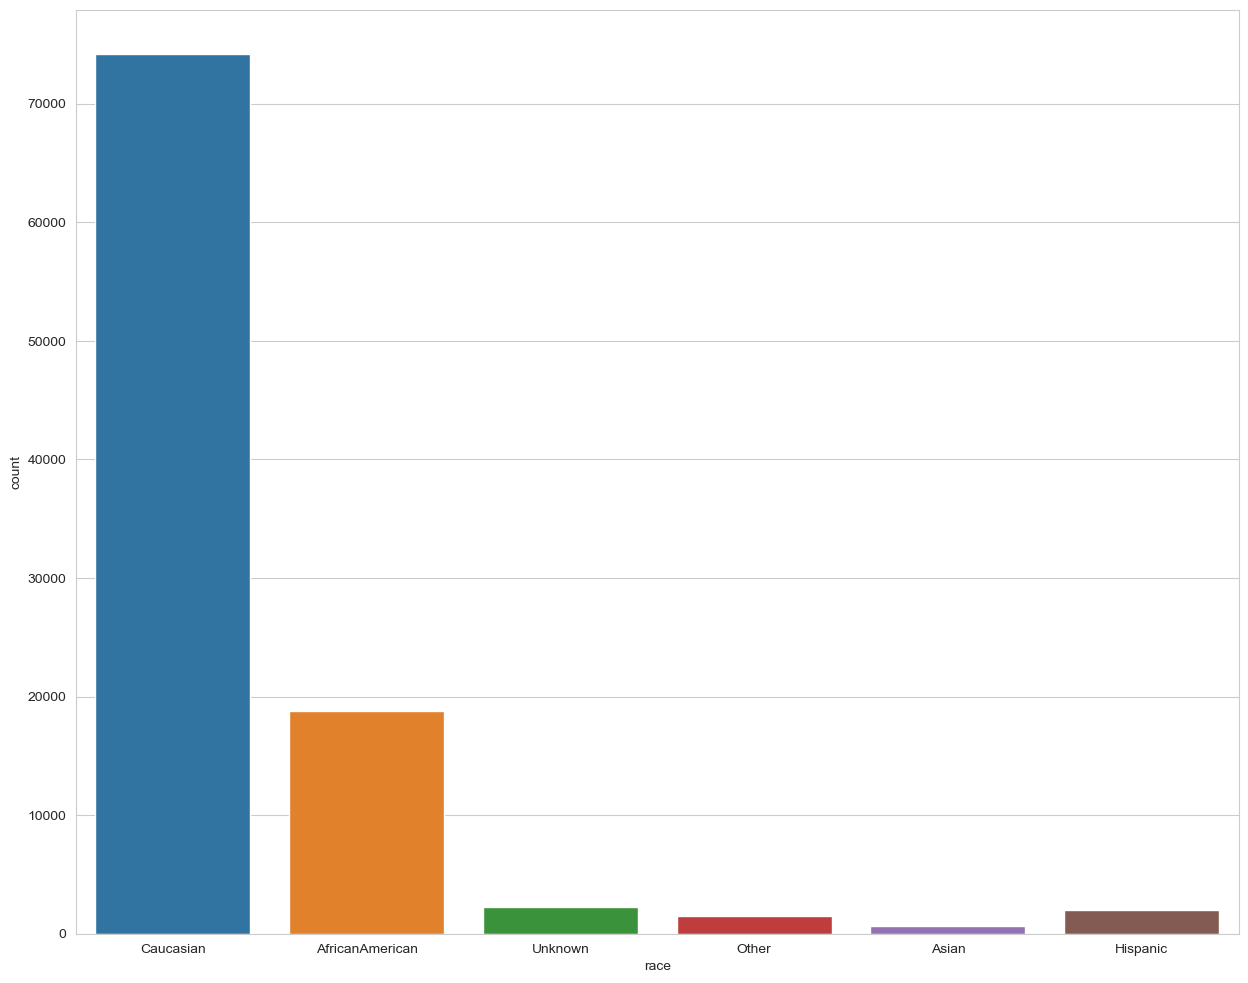

In [109]:
plt.figure(figsize=(15, 12)) 
sns.countplot(data=data, x="race") # Corrected function call
plt.show() 

In [110]:
race_dummies = pd.get_dummies(data['race'], prefix='race').astype(int)
data = pd.concat([data, race_dummies], axis=1)
data.drop(columns=['race'], inplace=True)


In [111]:
data["admission_type_id"].value_counts()

admission_type_id
Emergency        70516
Elective         18666
Not Available    10138
Name: count, dtype: int64

In [112]:
#admission
admission_type_map = {
    'Emergency': 1,
    'Elective': 2,
    'Not Available': 0
}

data['admission_type_id'] = (data['admission_type_id'].replace(admission_type_map)
)


In [113]:
discharge_map = {
    'Discharged to home': 1,
    
    'Transferred to another city': 2,
    'Expired': 3,
    'Left AMA': 4,
    'Still patient/referred to this institution': 5,
    'Not Available': 0
}

data['discharge_disposition_id'] = (data['discharge_disposition_id'].replace(discharge_map))

In [114]:
admission_source_map = {
    'Emergency': 1,
    'Referral': 2,
    'Transferred from hospital': 3,
    'Unknown': 0
}

data['admission_source_id'] = data['admission_source_id'].replace(admission_source_map)
data['admission_source_id'] = data['admission_source_id'].replace(8, 0)


In [115]:
data.columns


Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'service_utilization', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'race_Unknown'],
      dtype='object')

<Figure size 1200x1000 with 0 Axes>

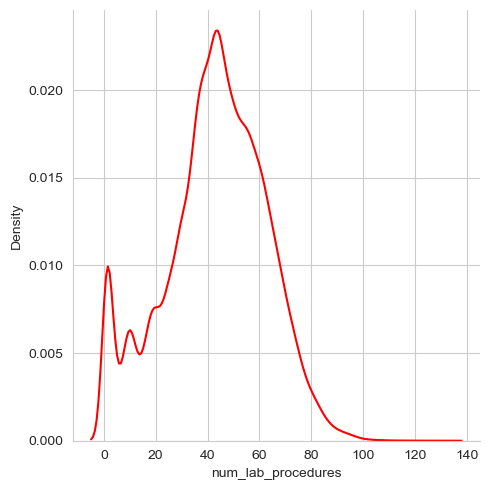

In [116]:
plt.figure(figsize=(12,10))
sns.displot(data["num_lab_procedures"],color="red",kind="kde")


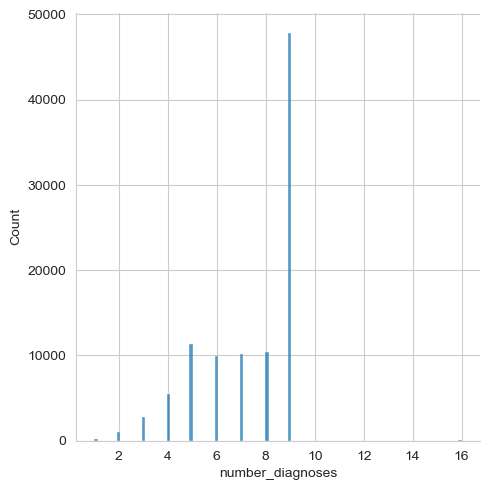

In [117]:
sns.displot(data,x="number_diagnoses", kind="hist")
plt.show()

- we have a dataset of diabetic patients. These columns are related to diagnoses and diabetes medications.
- I put them in a list because I want to process them together in a loop.

In [118]:
drug=list(data.iloc[:,16:39].columns)
print(drug)

['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change']


In [119]:
for i in drug:
    print(i,data[i].unique())

repaglinide ['No' 'Up' 'Steady' 'Down']
nateglinide ['No' 'Steady' 'Down' 'Up']
chlorpropamide ['No' 'Steady' 'Down' 'Up']
glimepiride ['No' 'Steady' 'Down' 'Up']
acetohexamide ['No' 'Steady']
glipizide ['No' 'Steady' 'Up' 'Down']
glyburide ['No' 'Steady' 'Up' 'Down']
tolbutamide ['No' 'Steady']
pioglitazone ['No' 'Steady' 'Up' 'Down']
rosiglitazone ['No' 'Steady' 'Up' 'Down']
acarbose ['No' 'Steady' 'Up' 'Down']
miglitol ['No' 'Steady' 'Down' 'Up']
troglitazone ['No' 'Steady']
tolazamide ['No' 'Steady' 'Up']
examide ['No']
citoglipton ['No']
insulin ['No' 'Up' 'Steady' 'Down']
glyburide-metformin ['No' 'Steady' 'Down' 'Up']
glipizide-metformin ['No' 'Steady']
glimepiride-pioglitazone ['No' 'Steady']
metformin-rosiglitazone ['No' 'Steady']
metformin-pioglitazone ['No' 'Steady']
change [0 1]


#### Important: Many drugs have mostly No values ,most patients don’t take them, so they add sparse information for modeling.

In [120]:
#Check proportions-
for col in drug:
    print(col)
    print(data[col].value_counts(normalize=True))
    print('-'*30)


repaglinide
repaglinide
No        0.984716
Steady    0.013774
Up        0.001077
Down      0.000433
Name: proportion, dtype: float64
------------------------------
nateglinide
nateglinide
No        0.993063
Steady    0.006585
Up        0.000242
Down      0.000111
Name: proportion, dtype: float64
------------------------------
chlorpropamide
chlorpropamide
No        0.999154
Steady    0.000775
Up        0.000060
Down      0.000010
Name: proportion, dtype: float64
------------------------------
glimepiride
glimepiride
No        0.948439
Steady    0.046395
Up        0.003242
Down      0.001923
Name: proportion, dtype: float64
------------------------------
acetohexamide
acetohexamide
No        0.99999
Steady    0.00001
Name: proportion, dtype: float64
------------------------------
glipizide
glipizide
No        0.873862
Steady    0.112928
Up        0.007692
Down      0.005518
Name: proportion, dtype: float64
------------------------------
glyburide
glyburide
No        0.894070
Steady    0

# Insights
-  Most columns like repaglinide, nateglinide, chlorpropamide have <1% of patients taking them.

- Only a few drugs like metformin or insulin have significant usage.

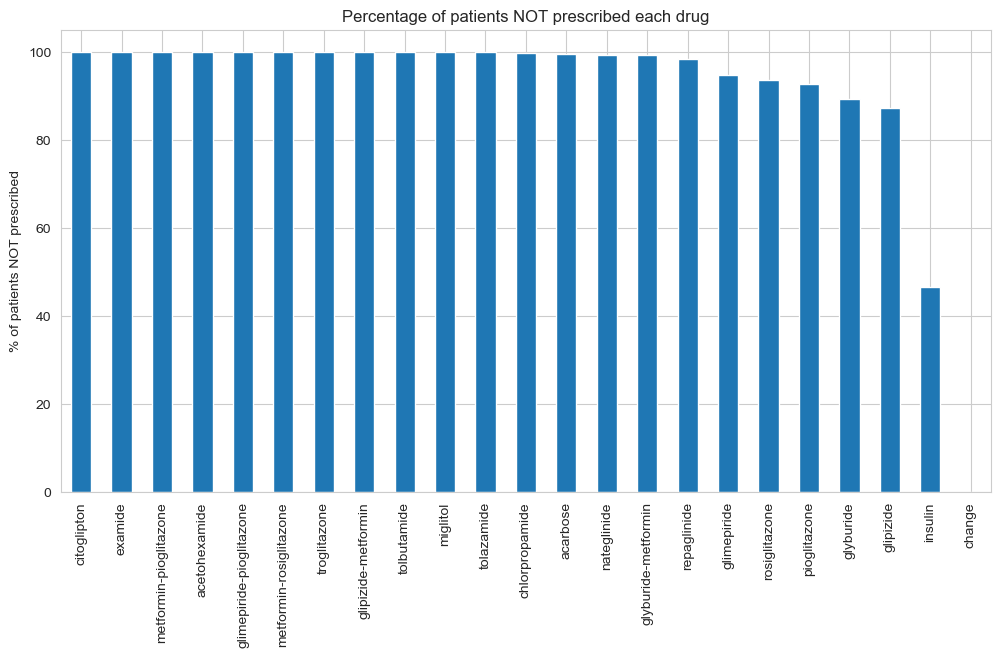

In [121]:
no_percentage = {col: (data[col]=='No').mean()*100 for col in drug}
no_df = pd.DataFrame.from_dict(no_percentage, orient='index', columns=['% No'])

no_df.sort_values('% No', ascending=False, inplace=True)
no_df.plot(kind='bar', figsize=(12,6), legend=False)
plt.ylabel('% of patients NOT prescribed')
plt.title('Percentage of patients NOT prescribed each drug')
plt.show()


In [122]:
#add noise
drop_cols = [
    'examide',
    'citoglipton',
    
]
data.drop(columns=drop_cols, inplace=True)
# These columns have zero variance and do not contribute to model learning.

In [123]:
import plotly.express as px

# Convert drugs to binary: 0 = No, 1 = any other value
drug_cols = ['number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone']

drug_binary = data[drug_cols].applymap(lambda x: 0 if x=='No' else 1)

# Calculate proportion of patients who take each drug
drug_prop = (drug_binary.sum() / len(data) * 100).reset_index()
drug_prop.columns = ['Drug', 'Percent_Patients']

# Horizontal bar plot
fig = px.bar(drug_prop, 
             y='Drug', 
             x='Percent_Patients', 
             text='Percent_Patients', 
             color='Percent_Patients', 
             color_continuous_scale='Blues',
             title='Percentage of Patients Prescribed Each Drug',
             orientation='h')

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(height=700)
fig.show()


In [124]:
#Convert drugs to binary (No = 0, any = 1)
drug_binary = data[drug_cols].applymap(lambda x: 0 if x=='No' else 1)
#calculate percentage  of patients on each drug
drug_prop = (drug_binary.sum() / len(data) * 100).reset_index()
drug_prop.columns = ['Drug', 'Percent_Patients']
drug_prop = drug_prop.sort_values(by='Percent_Patients', ascending=False)
print(drug_prop)


                        Drug  Percent_Patients
0           number_diagnoses        100.000000
1              max_glu_serum        100.000000
2                  A1Cresult        100.000000
18                   insulin         53.316553
3                  metformin         19.977849
9                  glipizide         12.613774
10                 glyburide         10.593033
12              pioglitazone          7.302658
13             rosiglitazone          6.346154
7                glimepiride          5.156061
4                repaglinide          1.528393
19       glyburide-metformin          0.701772
5                nateglinide          0.693717
14                  acarbose          0.307088
6             chlorpropamide          0.084575
17                tolazamide          0.039267
15                  miglitol          0.038260
11               tolbutamide          0.021144
20       glipizide-metformin          0.013089
16              troglitazone          0.003021
22   metformi

- From this, we can see which drugs are actually used and which are almost never prescribed.
- Drop very rare drugs (<1%) because they are mostly "No" → low variance → noisy for modeling

In [125]:
drugs_to_drop= ['repaglinide', 'nateglinide', 'chlorpropamide', 'acetohexamide',
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                'miglitol', 'troglitazone', 'tolazamide',
                'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
                'metformin-rosiglitazone','metformin-pioglitazone']
data = data.drop(columns=drugs_to_drop)


# These drugs are used by <1% of patients.
- Columns are sparse, mostly "No" values → low variance.
- Including them adds noise and does not improve model performance.
- Removing them simplifies data, reduces overfitting risk, and speeds up training.
# Many columns will be dropped because:

Sparse >99% No = contributes almost no info

Low effect on readmitted  won’t improve model

In [126]:
l1=["metformin","glimepiride","glyburide","glipizide"]

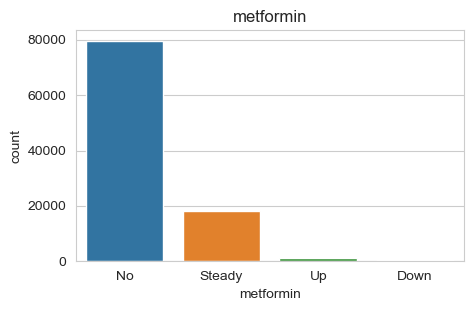

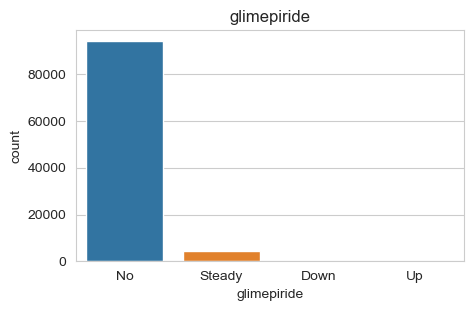

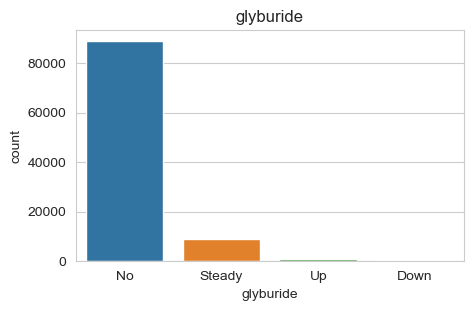

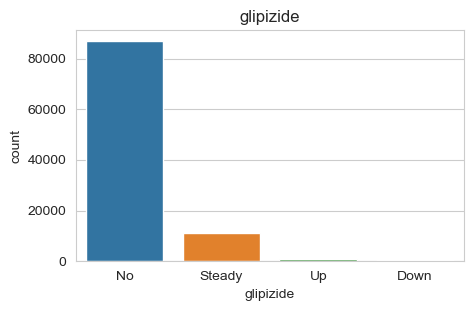

In [127]:
for col in l1:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=data)
    plt.title(col)
    plt.show()


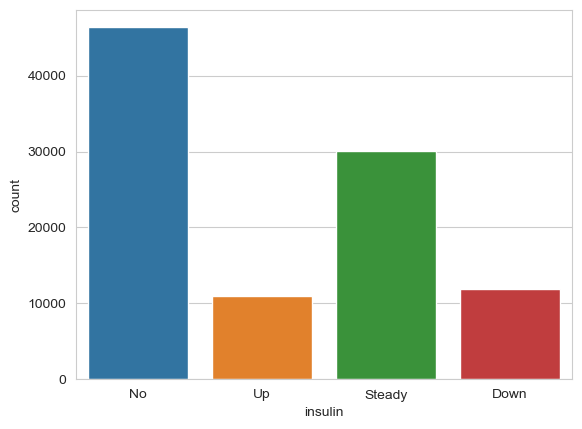

In [128]:
sns.countplot(x='insulin', data=data)
plt.show()


In [129]:
#ordinal encoding
drug_map = {
    'No': 0,
    'Down': 1,
    'Steady': 2,
    'Up': 3
}

drug_cols = ['metformin','glimepiride','glipizide',
             'glyburide','insulin']

for col in drug_cols:
    data[col] = data[col].map(drug_map).astype(int)

In [130]:
def diag_group(code):
    try:
        code = float(code)
    except:
        return 0   # Unknown / non-numeric

    if 390 <= code <= 459 or code == 785:
        return 1   # Circulatory
    elif 460 <= code <= 519 or code == 786:
        return 2   # Respiratory
    elif 520 <= code <= 579 or code == 787:
        return 3   # Digestive
    elif code == 250:
        return 4   # Diabetes
    elif 800 <= code <= 999:
        return 5   # Injury
    else:
        return 6   # Other
for col in ['diag_1','diag_2','diag_3']:
    data[col] = data[col].apply(diag_group).astype(int)

In [131]:
data[['diag_1','diag_2','diag_3']].value_counts()


diag_1  diag_2  diag_3
6       6       6         11806
1       1       1          6708
6       6       1          4155
1       1       6          3990
        6       6          3118
                          ...  
0       4       2             1
        0       5             1
4       3       0             1
        5       0             1
0       3       2             1
Name: count, Length: 305, dtype: int64

- Originally each of these columns stored ICD-9 diagnosis codes:
- diag_1	Primary diagnosis (main reason for admission)
- diag_2	Secondary diagnosis
- diag_3	Additional diagnosis

- we did NOT keep ICD codes You converted them into diagnosis GROUPS
  Original problem
- 1000+ unique ICD codes High cardinality Impossible to one-hot encode     safely

- After grouping
- Only 7 numeric categories
- Medical meaning preserved
- Models learn patterns better
### I did Feature engineering using domain knowledge using data undestanding

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99320 entries, 0 to 101765
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender                    99320 non-null  int64
 1   age                       99320 non-null  int64
 2   admission_type_id         99320 non-null  int64
 3   discharge_disposition_id  99320 non-null  int64
 4   admission_source_id       99320 non-null  int64
 5   time_in_hospital          99320 non-null  int64
 6   num_lab_procedures        99320 non-null  int64
 7   num_procedures            99320 non-null  int64
 8   num_medications           99320 non-null  int64
 9   diag_1                    99320 non-null  int32
 10  diag_2                    99320 non-null  int32
 11  diag_3                    99320 non-null  int32
 12  number_diagnoses          99320 non-null  int64
 13  max_glu_serum             99320 non-null  int64
 14  A1Cresult                 99320 non-null  

## bivariate and multivariate analysis

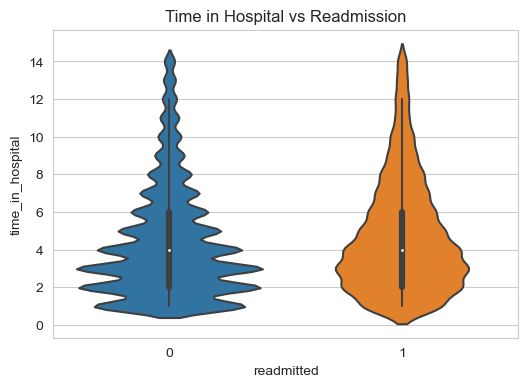

In [133]:
plt.figure(figsize=(6,4))
sns.violinplot(x='readmitted', y='time_in_hospital', data=data)
plt.title("Time in Hospital vs Readmission")
plt.show()


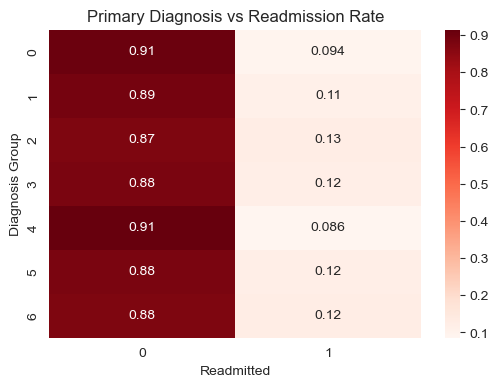

In [134]:
diag_readmit = pd.crosstab(data['diag_3'], data['readmitted'], normalize='index')

plt.figure(figsize=(6,4))
sns.heatmap(diag_readmit, annot=True, cmap='Reds')
plt.title("Primary Diagnosis vs Readmission Rate")
plt.xlabel("Readmitted")
plt.ylabel("Diagnosis Group")
plt.show()


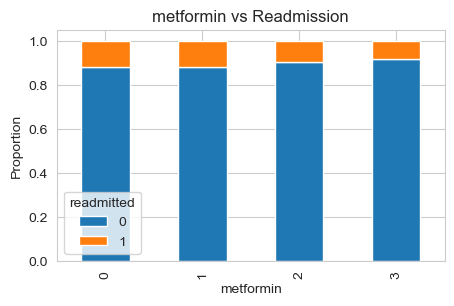

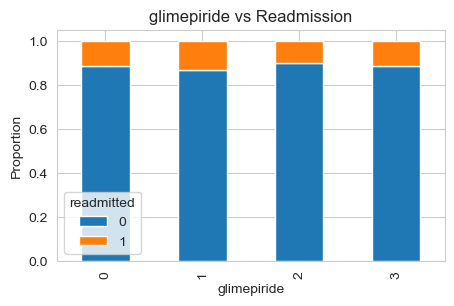

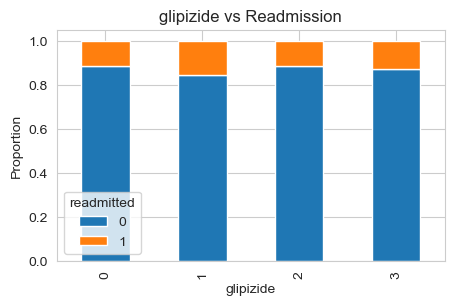

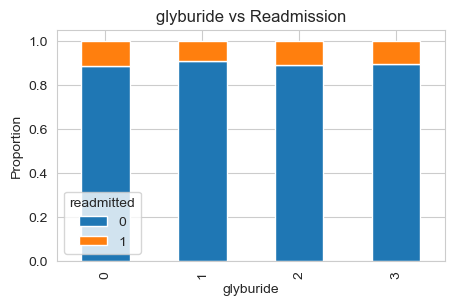

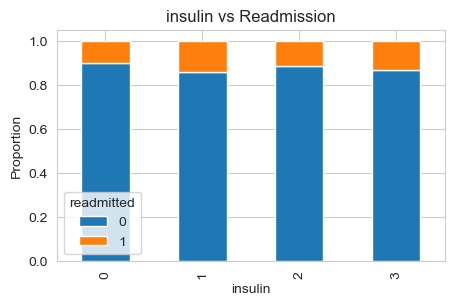

In [135]:
drug_cols = ['metformin','glimepiride','glipizide','glyburide','insulin']

for drug in drug_cols:
    ct = pd.crosstab(data[drug], data['readmitted'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(5,3), title=f"{drug} vs Readmission")
    plt.ylabel("Proportion")
    plt.show()


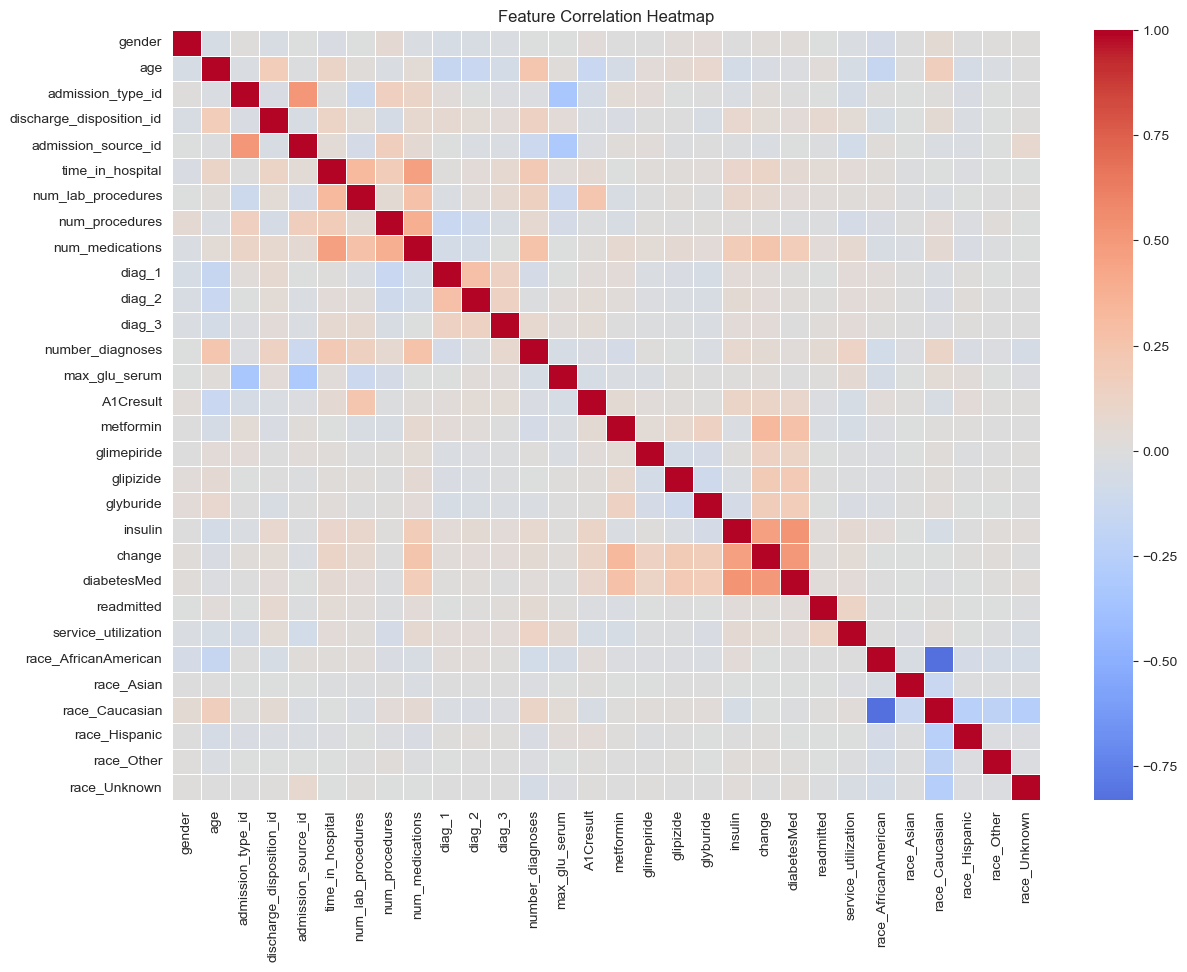

In [136]:
plt.figure(figsize=(14,10))
sns.heatmap(
    data.corr(),
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Feature Correlation Heatmap')
plt.show()


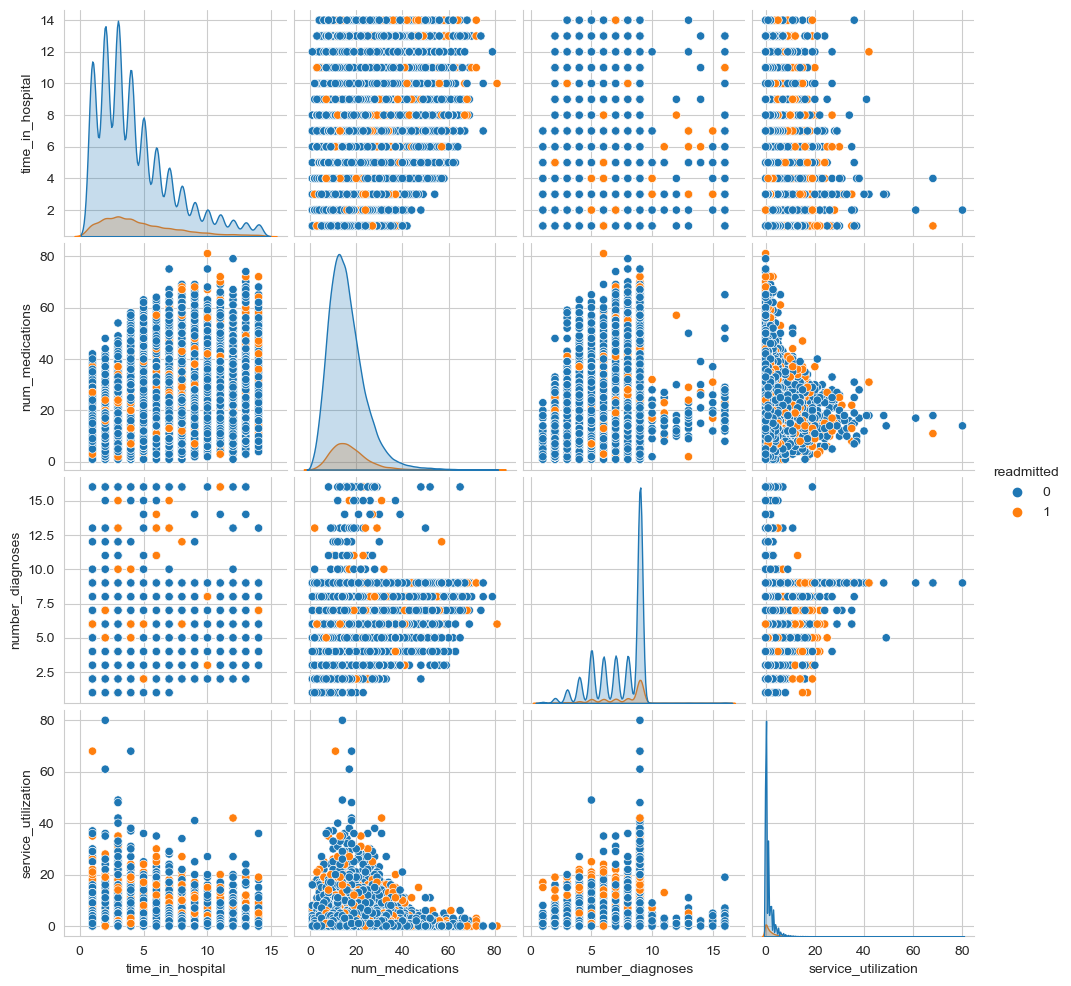

In [137]:
#Pairwise interaction
important_cols = [
    'time_in_hospital',
    'num_medications',
    'number_diagnoses',
    'service_utilization',
    'readmitted'
]

sns.pairplot(data[important_cols], hue='readmitted', diag_kind='kde')
plt.show()


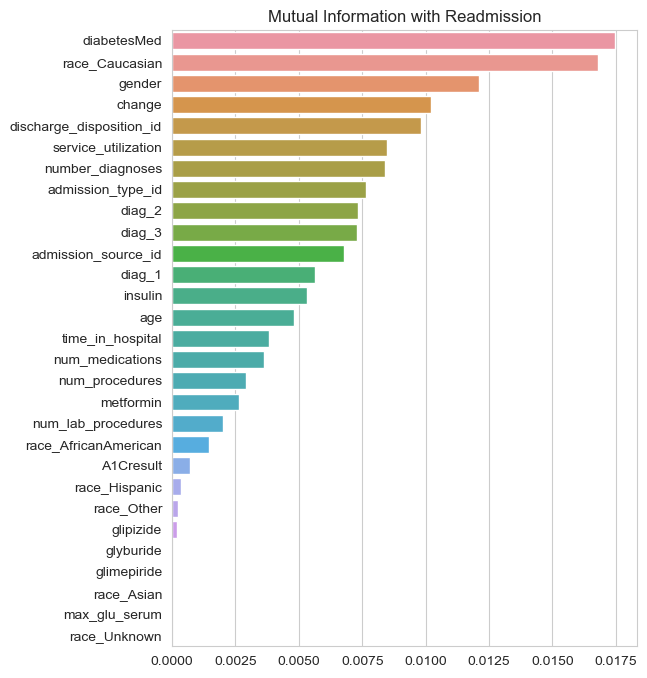

In [138]:
#Feature importance preview
from sklearn.feature_selection import mutual_info_classif

X = data.drop('readmitted', axis=1)
y = data['readmitted']

mi = mutual_info_classif(X, y)
mi_df = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x=mi_df.values, y=mi_df.index)
plt.title("Mutual Information with Readmission")
plt.show()


In [139]:
data["race_Other"].value_counts()

race_Other
0    97849
1     1471
Name: count, dtype: int64

In [140]:
drop_cols = [
    'glyburide',
    "race_Other"
]
data = data.drop(columns=drop_cols)

- Features like diabetesMed, race_Caucasian, change, and gender have the highest scores, suggesting they are the most informative for predicting readmission status. 
- Features with near-zero scores, such as race_Other, glyburide, and glipizide, provide very little or no information about the target variable. 


# we keep imbalaced and balanced data to check accuracy

# Model Building

In [141]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (69524, 27)
y_train (69524,)
X_test (29796, 27)
y_test (29796,)


In [142]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,
roc_auc_score,confusion_matrix,classification_report,roc_curve)
from sklearn.model_selection import (cross_val_score,GridSearchCV,RandomizedSearchCV)



# Logistic Regression Unbalanced data

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

lr_unbal = LogisticRegression(max_iter=1000)
lr_unbal.fit(X_train, y_train)

y_pred = lr_unbal.predict(X_test)

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, lr_unbal.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     26402
           1       0.28      0.00      0.01      3394

    accuracy                           0.89     29796
   macro avg       0.58      0.50      0.47     29796
weighted avg       0.82      0.89      0.83     29796

AUC: 0.6303821356545327


# Logistic Regression balanced data

In [144]:
lr_bal = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

lr_bal.fit(X_train, y_train)
y_pred = lr_bal.predict(X_test)

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, lr_bal.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.92      0.65      0.76     26402
           1       0.17      0.54      0.25      3394

    accuracy                           0.64     29796
   macro avg       0.54      0.59      0.51     29796
weighted avg       0.83      0.64      0.70     29796

AUC: 0.6336661027760035


# Decision Tree Unbalanced data

In [145]:
dt_unbal = DecisionTreeClassifier(random_state=42)
dt_unbal.fit(X_train, y_train)

y_pred = dt_unbal.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.87      0.88     26402
           1       0.15      0.18      0.16      3394

    accuracy                           0.79     29796
   macro avg       0.52      0.52      0.52     29796
weighted avg       0.81      0.79      0.80     29796



# Decision Tree balanced data

In [146]:
dt_bal = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

dt_bal.fit(X_train, y_train)
y_pred = dt_bal.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.89      0.89     26402
           1       0.14      0.14      0.14      3394

    accuracy                           0.80     29796
   macro avg       0.52      0.52      0.52     29796
weighted avg       0.80      0.80      0.80     29796



# Random forest (RandomizedSearchCV )

In [147]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rs_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    random_state=42
)

rs_rf.fit(X_train, y_train)

best_rf1 = rs_rf.best_estimator_

y_pred = best_rf1.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.60      0.73     26402
           1       0.17      0.63      0.27      3394

    accuracy                           0.60     29796
   macro avg       0.55      0.61      0.50     29796
weighted avg       0.84      0.60      0.68     29796



# Random Forest With Best Threshold

In [149]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,          
    max_depth=10,              
    min_samples_split=5,
    class_weight='balanced',   # important for imbalanced dataset
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [167]:
y_prob_train = rf_model.predict_proba(X_train)[:, 1]


thresholds = [0.40, 0.45, 0.48, 0.5,0.55]
best_threshold = 0.5
best_recall = 0

from sklearn.metrics import recall_score

for t in thresholds:
    y_pred_t = (y_prob_train > t).astype(int)
    r = recall_score(y_train, y_pred_t)
    print(f"Threshold {t:.2f} -> Recall: {r:.4f}")
    if r > best_recall:
        best_recall = r
        best_threshold = t

print("Selected threshold:", best_threshold)


Threshold 0.40 -> Recall: 0.9095
Threshold 0.45 -> Recall: 0.7903
Threshold 0.48 -> Recall: 0.7058
Threshold 0.50 -> Recall: 0.6522
Threshold 0.55 -> Recall: 0.5148
Selected threshold: 0.4


In [168]:
y_prob_test = rf_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test > best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.94      0.38      0.54     26402
           1       0.14      0.80      0.24      3394

    accuracy                           0.43     29796
   macro avg       0.54      0.59      0.39     29796
weighted avg       0.85      0.43      0.51     29796



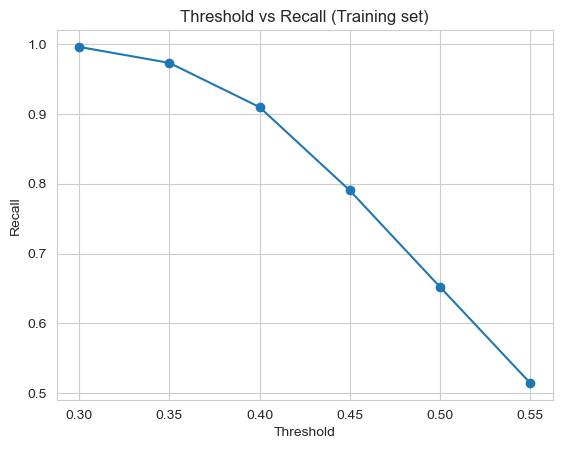

In [164]:


thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
recalls = []

y_prob_train = rf_model.predict_proba(X_train)[:,1]
for t in thresholds:
    y_pred_t = (y_prob_train > t).astype(int)
    recalls.append(recall_score(y_train, y_pred_t))

plt.plot(thresholds, recalls, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Threshold vs Recall (Training set)")
plt.grid(True)
plt.show()


# XG-BOOST Model

In [159]:
from xgboost import XGBClassifier
import numpy as np

scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.65      0.76     26402
           1       0.17      0.57      0.26      3394

    accuracy                           0.64     29796
   macro avg       0.55      0.61      0.51     29796
weighted avg       0.84      0.64      0.71     29796



In [160]:
xgb_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

xgb_importance.head(15)

Feature  Importance
21       service_utilization    0.144389
3   discharge_disposition_id    0.119091
12          number_diagnoses    0.043644
15                 metformin    0.041771
20               diabetesMed    0.036365
2          admission_type_id    0.033695
1                        age    0.033201
14                 A1Cresult    0.033187
5           time_in_hospital    0.032236
9                     diag_1    0.031336
24            race_Caucasian    0.029323
25             race_Hispanic    0.029079
11                    diag_3    0.028862
8            num_medications    0.028517
7             num_procedures    0.028239

In [169]:
import joblib

# Save model
joblib.dump(rf_model, "rf_readmission_model.pkl")

# Save threshold separately
joblib.dump(best_threshold, "rf_threshold.pkl")


['rf_threshold.pkl']